<a href="https://colab.research.google.com/github/slynj/MTSC-LSTM-floor-classification/blob/main/MTSC_LSTM_floor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# https://github.com/slynj/MTSC-LSTM-floor-classification

In [3]:
!nvidia-smi

Tue Apr  1 19:03:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
!pip install --quiet --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00


In [5]:
!pip install --quiet torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 167.7 MB/s eta 0:00:00


In [6]:
!pip install --quiet pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 31.1 MB/s eta 0:00:00


In [12]:
!unzip -q career-con-2019.zip

In [8]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(PALETTE))

rcParams['figure.figsize'] = 16, 10

In [10]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [13]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

In [14]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [15]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


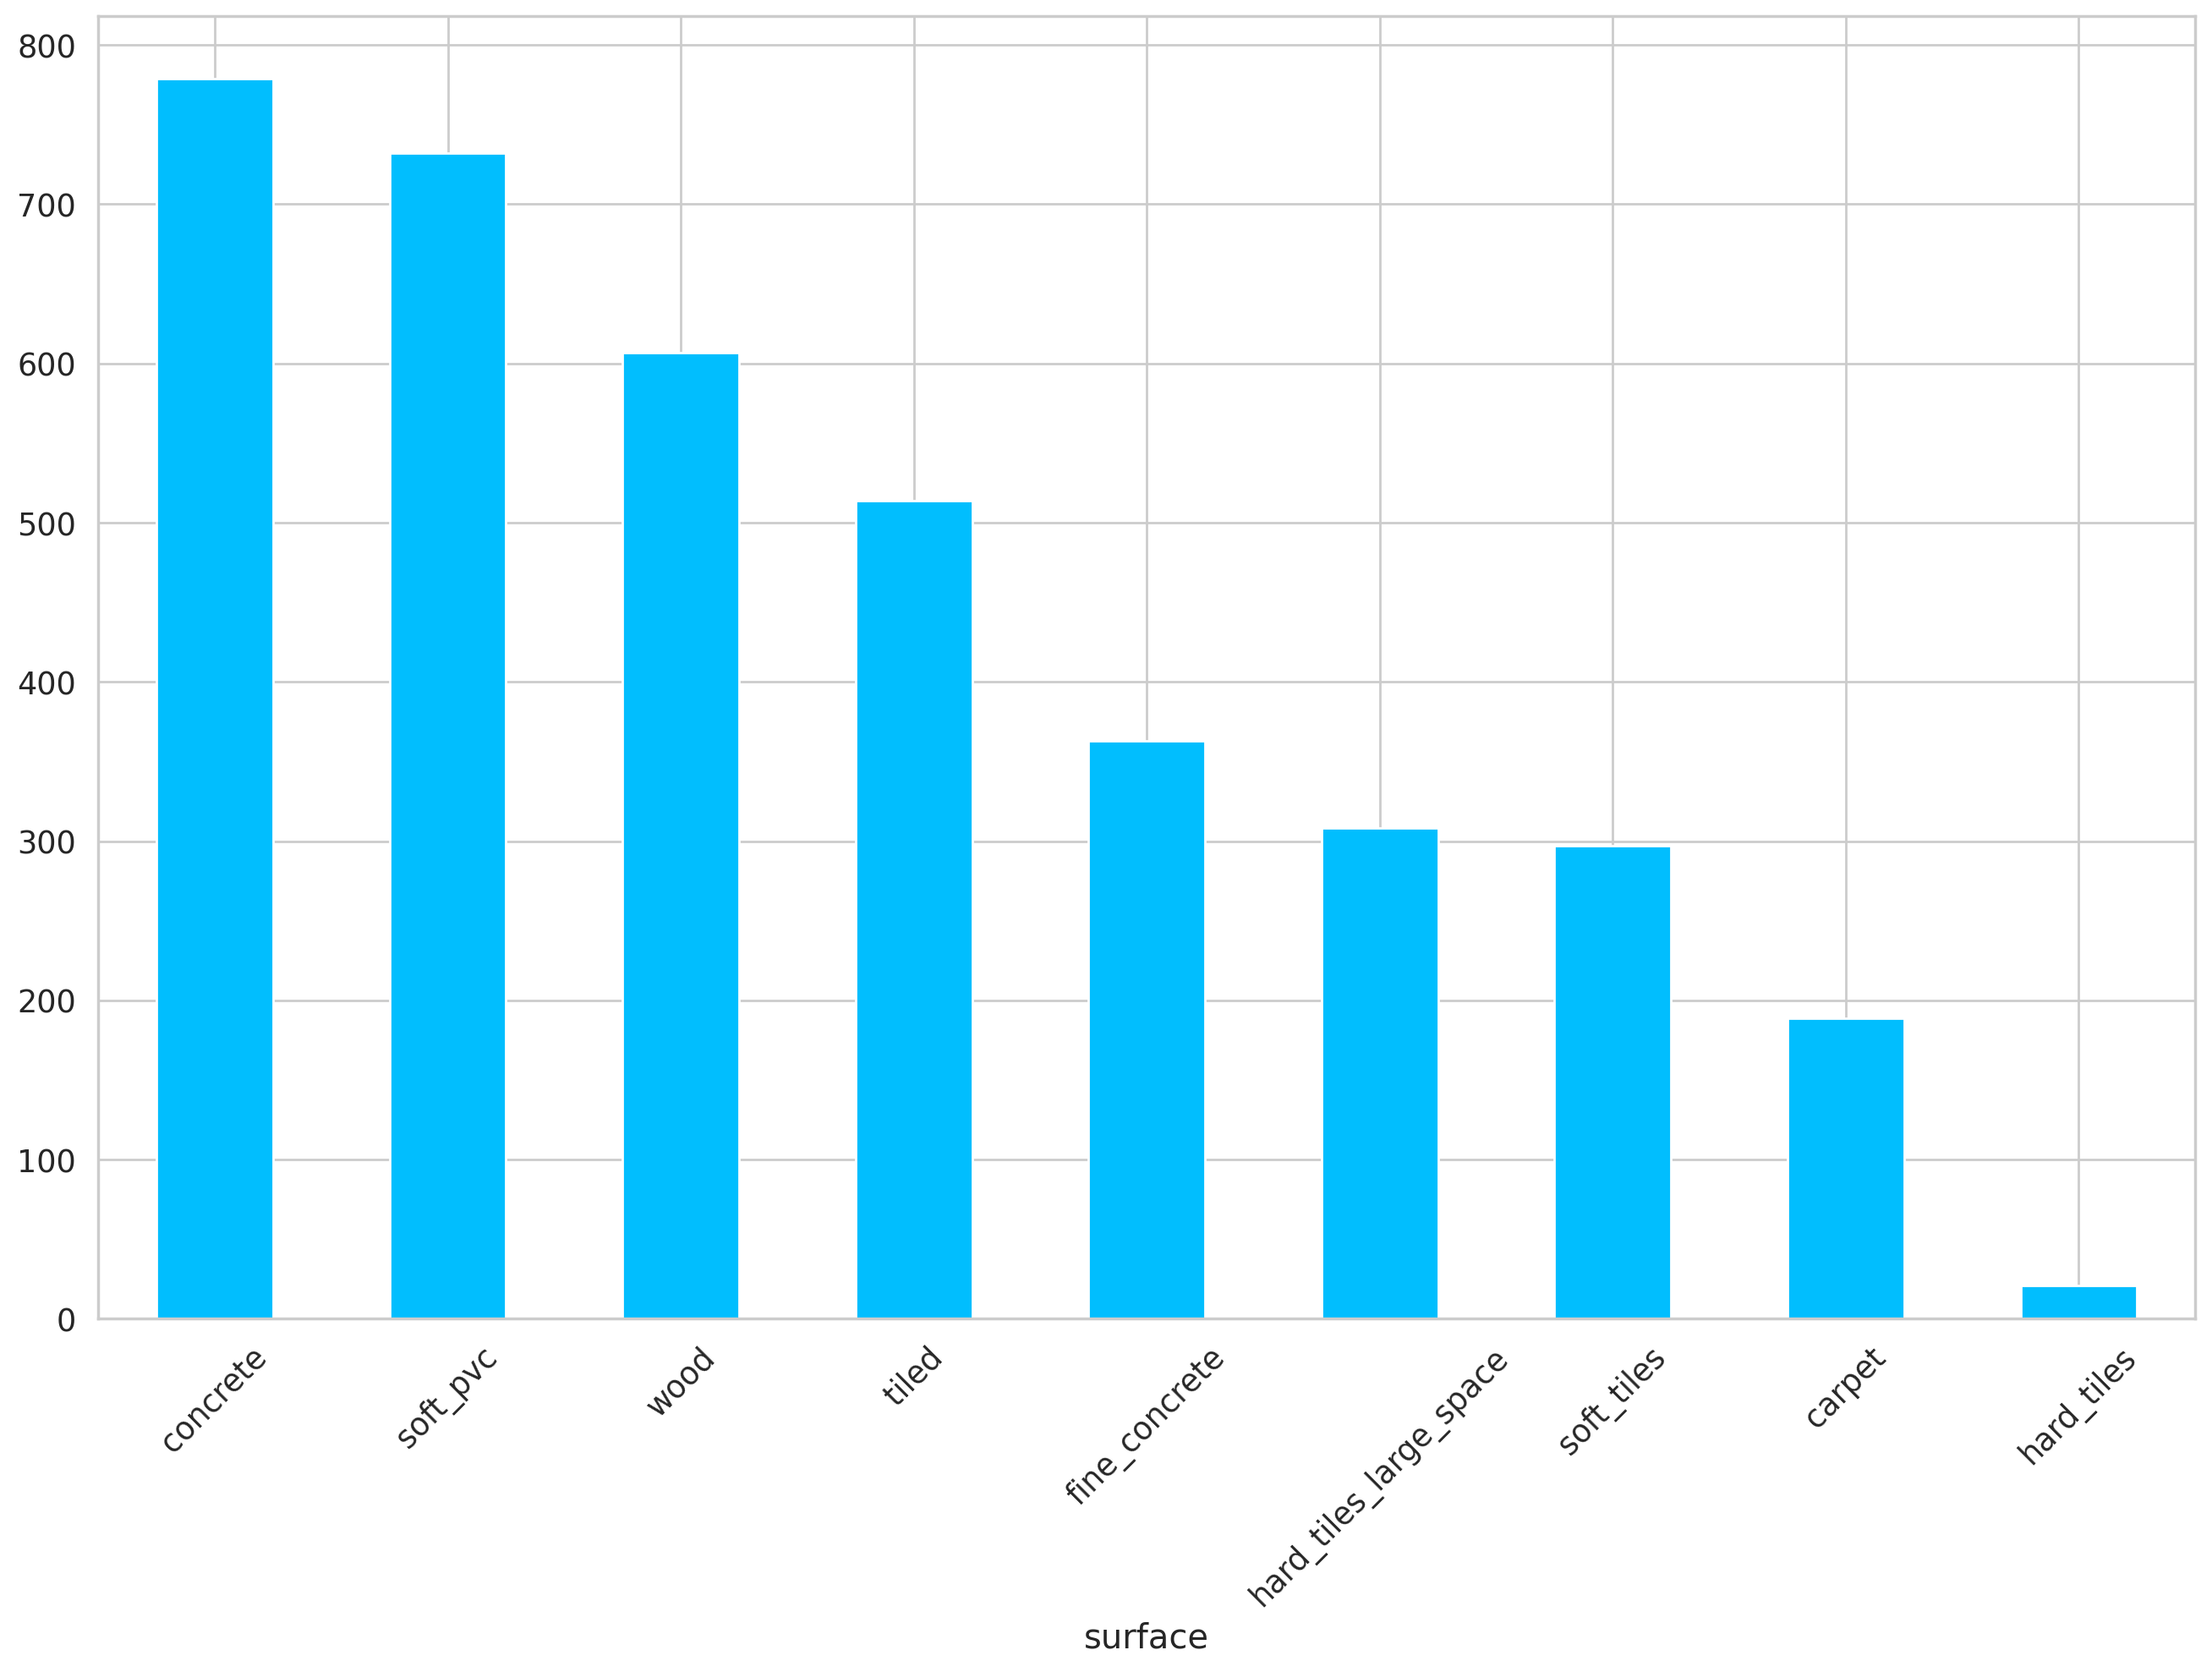

In [16]:
y_train.surface.value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

# Preprocessing

int label for the floor types

In [17]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)

In [18]:
encoded_labels[:5]

array([2, 1, 1, 1, 6])

In [19]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [20]:
y_train["label"] = encoded_labels

In [21]:
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


remove unnecessary cols -> extract feature col from X_train

In [22]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [23]:
FEATURE_COLS = X_train.columns.tolist()[3:]
FEATURE_COLS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

note that there are exactly 128 values per series id

In [24]:
X_train.series_id.value_counts()

,count
series_id,
3809,128
0,128
3770,128
3771,128
3772,128
...,...
5,128
6,128
7,128


In [25]:
(X_train.series_id.value_counts() == 128).sum()

np.int64(3810)

In [26]:
(X_train.series_id.value_counts() == 128).sum() == len(y_train)

np.True_

conert it to sequence. note that we just select the label value to be the label of the first data.

In [27]:
sequences = [ ]

for series_id, group in X_train.groupby("series_id"):
  sequence_features = group[FEATURE_COLS]
  label = y_train[y_train.series_id == series_id].iloc[0].label

  sequences.append((sequence_features, label))

note that the shape f this sequence is ([128 x 10], 2). so there are 10 features, and 128 data mapped with the value 2 (label value)

In [28]:
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

split into test and train cases

In [29]:
train_seq, test_seq = train_test_split(sequences, test_size=0.2)

In [30]:
len(train_seq), len(test_seq)

(3048, 762)

# Dataset

In [31]:
class SurfaceDataset(Dataset):
  def __init__(self, sequences):
    super().__init__()
    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    sequence, label = self.sequences[index]
    return dict(
        sequnce=torch.Tensor(sequence.to_numpy()),
        label=torch.tensor(label).long()
    )